## Qiita  Titanic 記事を参考にやってみた
### [タイタニック号乗客の生存予測モデルを立ててみる](https://qiita.com/suzumi/items/8ce18bc90c942663d1e6)
---

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('../data/train.csv')
train.Sex = train.Sex.replace(['male','female'],[0,1]) #性別が扱いづらいので男性0、女性1とする

In [4]:
# 欠損値の扱い
train["Age"].fillna(train.Age.median(), inplace = True)

([array([ 80.,  97., 372.]), array([216., 184., 491.])],
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <a list of 2 Lists of Patches objects>)

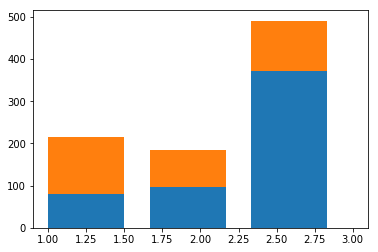

In [5]:
# 客室ごとのグレードごとにヒストグラム出力
split_data = []
for survived in [0,1]:
    split_data.append(train[train.Survived == survived])
    
temp = [i["Pclass"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=3, width = 0.5)

左から一等、二頭、三等でオレンジが生存した人、ブルーが死亡した人の割合が出ている
東急が上であるほど生存している割合が高い


([array([ 13.,  13.,   8.,  63.,  80., 191.,  47.,  39.,  30.,  23.,  14.,
          11.,  10.,   3.,   4.,   0.]),
  array([ 44.,  20.,  19.,  96., 122., 285.,  88.,  67.,  47.,  39.,  24.,
          18.,  14.,   3.,   4.,   1.])],
 array([ 0.42   ,  5.39375, 10.3675 , 15.34125, 20.315  , 25.28875,
        30.2625 , 35.23625, 40.21   , 45.18375, 50.1575 , 55.13125,
        60.105  , 65.07875, 70.0525 , 75.02625, 80.     ]),
 <a list of 2 Lists of Patches objects>)

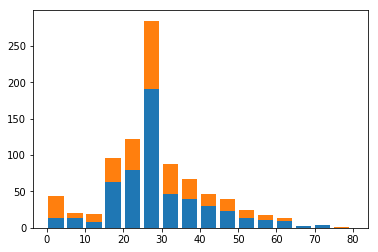

In [6]:
temp = [i["Age"].dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=16, width = 4.0)

Ageの欠損値を中央値でおいたため真ん中の突出が大きい

In [7]:
#年齢が欠損しているデータを除外したデータフレームを作成
train_ex_misval = pd.read_csv('../data/train.csv')
train_ex_misval = train_ex_misval.dropna()
train_ex_misval.Sex = train_ex_misval.Sex.replace(['male','female'],[0,1])


([array([ 2.,  0.,  0.,  4.,  5.,  5.,  3.,  9.,  5., 11.,  4.,  4.,  6.,
          1.,  1.,  0.]),
  array([ 9.,  1.,  3., 16., 23., 17., 21., 28., 11., 22., 11., 11.,  7.,
          1.,  1.,  1.])],
 array([ 0.92  ,  5.8625, 10.805 , 15.7475, 20.69  , 25.6325, 30.575 ,
        35.5175, 40.46  , 45.4025, 50.345 , 55.2875, 60.23  , 65.1725,
        70.115 , 75.0575, 80.    ]),
 <a list of 2 Lists of Patches objects>)

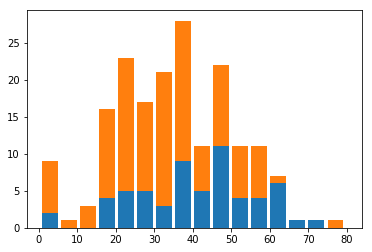

In [8]:
split_data_ex = []
for survived in [0,1]:
    split_data_ex.append(train_ex_misval[train_ex_misval.Survived == survived])
temp = [i["Age"].dropna() for i in split_data_ex]
plt.hist(temp, histtype="barstacked", bins=16, width = 4)

記事と少し結果が違うけど除外の仕方あってる？

- - -  
## ・データ整形
### 仮定: ５人以上の家族は生存率が低い？
### アプローチ: 家族の人数用の変数を用意して学習に利用

In [9]:
#新たなカラムFamilySizeを用意(Sibsp... 乗船している夫婦、兄弟姉妹の数, Parch...乗船している親、子供の数)
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
train_fm = train.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis=1)
print(train_fm)
train_fm.dtypes

     PassengerId  Survived  Pclass  Sex   Age  FamilySize
0              1         0       3    0  22.0           2
1              2         1       1    1  38.0           2
2              3         1       3    1  26.0           1
3              4         1       1    1  35.0           2
4              5         0       3    0  35.0           1
5              6         0       3    0  28.0           1
6              7         0       1    0  54.0           1
7              8         0       3    0   2.0           5
8              9         1       3    1  27.0           3
9             10         1       2    1  14.0           2
10            11         1       3    1   4.0           3
11            12         1       1    1  58.0           1
12            13         0       3    0  20.0           1
13            14         0       3    0  39.0           7
14            15         0       3    1  14.0           1
15            16         1       2    1  55.0           1
16            

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
FamilySize       int64
dtype: object

---
# ・実際に学習させてみる
## アプローチ: 
### Python機械学習ライブラリのScikit-learn からRandomForestClassifierを使って決定木を作成し予測する
 学習データとして必要なのはPclass以降変数であるため分離する。
 生存結果であるSuevivedは正解データとする

In [10]:
train_data = train_fm.values
xs = train_data[:, 2:] #Pclass以降の変数
y = train_data[:, 1] #正解データ

実際に学習させて予測モデルを作る
そしてtesc.csvもtrain.csv同様に整形

In [11]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)

#学習
forest = forest.fit(xs, y)

test_df = pd.read_csv("../data/test.csv").replace(["male","female"],[0,1])

#欠損値の補完
test_df["Age"].fillna(train.Age.median(), inplace=True)
test_df["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test_df_arranged = test_df.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis=1)

In [12]:
test_data = test_df_arranged.values
xs_test = test_data[:, 1:]
output = forest.predict(xs_test)

print(len(test_data[:,0]), len(output))
zip_data = zip(test_data[:,0].astype(int), output.astype(int))
predict_data = list(zip_data)

(418, 418)


最後にリストをcsvに書き込み

In [13]:
import csv
with open("../result/predict_result_qiita.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_data[:,0].astype(int), output.astype(int)):
        writer.writerow([pid, survived])

# ・結果
## 0.69856
---

In [16]:
#dotファイルを出力
#from sklearn import tree
#for i,val in enumerate(forest.estimators_):
#    tree.export_graphviz(forest.estimators_[i], out_file='tree_%d.dot'%i)
# >dot -Tpng tree_0.dot -o tree.png

## ・treeの表示
<img src="tree.png">